##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np

import tensorflow as tf

In [ ]:
import datasets
ds = datasets.load_dataset('SetFit/emotion')

ds = ds.with_format('tf')
ds

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

In [ ]:
label_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

NUM_CLASSES = len(label_names)

print('NUM_CLASSES:', NUM_CLASSES)
print('label_names:', label_names)

NUM_CLASSES: 6
label_names: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


Import `matplotlib` and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [ ]:
# BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = ds['train'].to_tf_dataset(
  columns=["text"],
  label_cols=["label"],
  batch_size=BATCH_SIZE,
  shuffle=True
).prefetch(tf.data.AUTOTUNE)

valid_dataset = ds['validation'].to_tf_dataset(
  columns=['text'],
  label_cols=['label'],
  batch_size=BATCH_SIZE,
).prefetch(tf.data.AUTOTUNE)

test_dataset = ds['test'].to_tf_dataset(
  columns=['text'],
  label_cols=['label'],
  batch_size=BATCH_SIZE,
).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'i also feel i do not deserve anyones sympathy or help or caring because i do not feel worthy of anything'
 b'i workout every morning before and feel fabulous for it'
 b'i am already feeling anxious then how is going off my anti anxiety medicine going to help me']

labels:  [2 1 4]


## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'feel', 'and', 'to', 'the', 'a', 'that',
       'feeling', 'of', 'my', 'in', 'it', 'like', 'so', 'for', 'im', 'me',
       'but'], dtype='<U13')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2, 117,   3,   2,  39,  26,   1,   1,   1,  35, 139,  35, 437,
         37,   2,  39,  26,   3,   1,  10, 166,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  2,   1, 147, 237, 176,   4,   3, 717,  16,  13,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  2,  24, 208,   9, 335, 125,  53,  22,  87, 168,  11,   1,   1,
          1,  87,   5, 139,  18,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'i also feel i do not deserve anyones sympathy or help or caring because i do not feel worthy of anything'
Round-trip:  i also feel i do not [UNK] [UNK] [UNK] or help or caring because i do not feel [UNK] of anything                     

Original:  b'i workout every morning before and feel fabulous for it'
Round-trip:  i [UNK] every morning before and feel fabulous for it                                

Original:  b'i am already feeling anxious then how is going off my anti anxiety medicine going to help me'
Round-trip:  i am already feeling anxious then how is going off my [UNK] [UNK] [UNK] going to help me                        



## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES),
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[ 0.00223287  0.00026551 -0.01244256  0.01049028 -0.01439986 -0.01673145]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 129ms/step
[ 0.00223287  0.00026551 -0.01244256  0.01049028 -0.01439986 -0.01673146]


Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=valid_dataset,
                    validation_steps=30)

Epoch 1/10
250/250 [==============================] - 14s 29ms/step - loss: 1.6574 - accuracy: 0.3248 - val_loss: 1.5791 - val_accuracy: 0.3510
Epoch 2/10
250/250 [==============================] - 5s 19ms/step - loss: 1.5536 - accuracy: 0.3459 - val_loss: 1.5334 - val_accuracy: 0.3594
Epoch 3/10
250/250 [==============================] - 5s 19ms/step - loss: 1.4280 - accuracy: 0.3791 - val_loss: 1.3270 - val_accuracy: 0.4245
Epoch 4/10
250/250 [==============================] - 5s 19ms/step - loss: 1.2043 - accuracy: 0.4894 - val_loss: 1.1849 - val_accuracy: 0.4938
Epoch 5/10
250/250 [==============================] - 5s 19ms/step - loss: 1.0806 - accuracy: 0.5648 - val_loss: 1.0766 - val_accuracy: 0.5745
Epoch 6/10
250/250 [==============================] - 5s 19ms/step - loss: 0.9428 - accuracy: 0.6631 - val_loss: 0.9143 - val_accuracy: 0.6922
Epoch 7/10
250/250 [==============================] - 5s 21ms/step - loss: 0.7898 - accuracy: 0.7439 - val_loss: 0.8008 - val_accuracy: 0.748

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

32/32 [==============================] - 0s 8ms/step - loss: 0.5987 - accuracy: 0.8140
Test Loss: 0.5986530780792236
Test Accuracy: 0.8140000104904175


(0.0, 1.712758669257164)

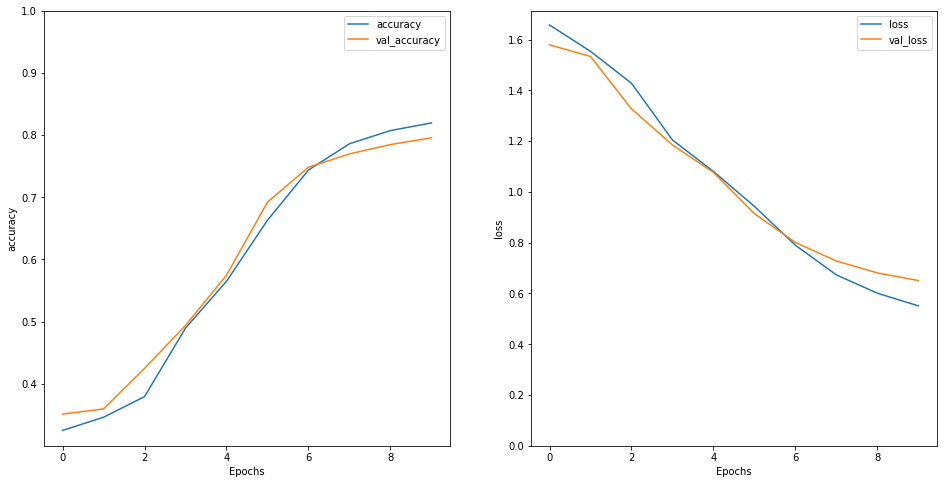

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-2.0950859   1.8615806   2.2454069  -1.3414228  -0.10391662 -1.289812  ]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True )),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True )),
    tf.keras.layers.Dropout(0.65),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True )),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True )),
    tf.keras.layers.Dropout(0.55),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True )),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES),
])

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=43,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/43
250/250 [==============================] - 93s 216ms/step - loss: 1.6388 - accuracy: 0.3223 - val_loss: 1.5656 - val_accuracy: 0.3484
Epoch 2/43
250/250 [==============================] - 39s 157ms/step - loss: 1.6110 - accuracy: 0.3171 - val_loss: 1.5627 - val_accuracy: 0.3484
Epoch 3/43
250/250 [==============================] - 39s 157ms/step - loss: 1.5994 - accuracy: 0.3240 - val_loss: 1.5625 - val_accuracy: 0.3510
Epoch 4/43
250/250 [==============================] - 39s 157ms/step - loss: 1.5963 - accuracy: 0.3268 - val_loss: 1.5601 - val_accuracy: 0.3547
Epoch 5/43
250/250 [==============================] - 41s 163ms/step - loss: 1.5858 - accuracy: 0.3492 - val_loss: 1.5435 - val_accuracy: 0.3844
Epoch 6/43
250/250 [==============================] - 40s 160ms/step - loss: 1.5613 - accuracy: 0.3871 - val_loss: 1.5184 - val_accuracy: 0.4161
Epoch 7/43
250/250 [==============================] - 39s 156ms/step - loss: 1.5415 - accuracy: 0.4027 - val_loss: 1.5187 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

32/32 [==============================] - 2s 55ms/step - loss: 0.3584 - accuracy: 0.8815
Test Loss: 0.3584365248680115
Test Accuracy: 0.8815000057220459


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 13s 13s/step
[[-0.666607    0.8690168  -1.9282569  -0.18540697 -0.53662306 -0.53804916]]


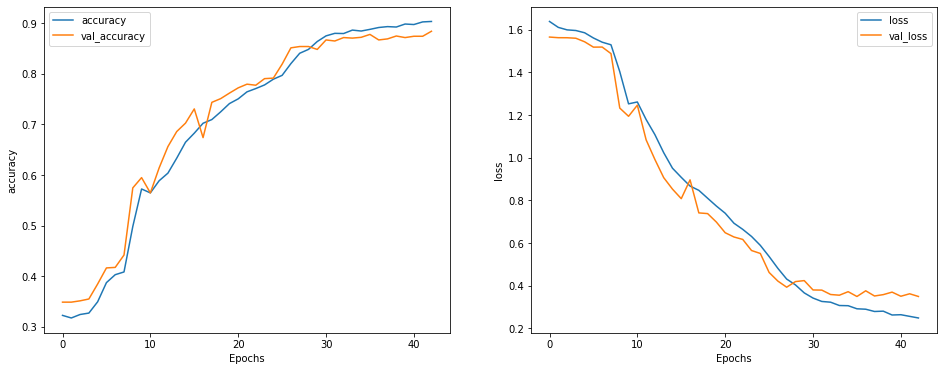

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
